In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
import dash
import dash_bootstrap_components as dbc
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Input, Output, State
import webbrowser
from threading import Timer

In [24]:
from quaternion import Quaternion

In [25]:
from buoy_data_analysis_with_madgwick import *

# Raw Data

### Acceleration [N, 3]
x, y, and z acceleration in the sensor frame

### Magnetic Field [N, 3]

x, y, z strength of the magnetic field in the sensor frame

### Angular Velocity [N, 3]

x, y, z angular velocity around the x y and z axes

### Height [N, 1]

Altitude

### Time [N, 1]

Given in seconds



         ax        ay   az  bx  by  bz  wx  wy  wz     h         t
0  0.000000  4.909122 -9.8   0   0   0   0   0   0  3.33  0.000000
1  0.487981  3.706931 -9.8   0   0   0   0   0   0  3.33  0.097752
2  0.971302  4.127254 -9.8   0   0   0   0   0   0  3.33  0.195503
3  1.445350  5.247011 -9.8   0   0   0   0   0   0  3.33  0.293255
4  1.905597  5.408259 -9.8   0   0   0   0   0   0  3.33  0.391007


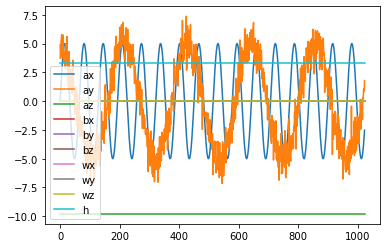

In [39]:
def make_fake_data(n):
    labels = ['ax','ay','az','bx','by','bz','wx','wy','wz','h','t']
    df = pd.DataFrame(columns=labels)
    t = np.linspace(0, 1, n)*100
    noise = np.random.normal(0,1,n)
    df.t = t
    df.ax = np.sin(t)*5
    df.ay = np.cos(t*.3)*5 + noise
    df.az = [-9.8]*n
    df.bx = [0]*n
    df.by = [0]*n
    df.bz = [0]*n
    df.wx = [0]*n #+ np.random.normal(0,1,n)
    df.wy = [0]*n
    df.wz = [0]*n
    df.h = [3.33]*n
    df.to_excel("data/fake_data.xlsx")
    return df
    
df = make_fake_data(1024)
print(df.head())
df.drop('t',axis=1).plot()

# Madgwick Update

Calculates quaternions between the sensor frame and the earth frame using Acceleration, orbital velocity and magnetic field.

## frequency [float]

$f=\frac{1}{dt}$

## dt [float]

time in between samples

$dt = \frac{1.0}{f}$


## q0
initial quaternion object.

Can be unit quaternion that doesn't actually rotate anything.

i = np.array([1, 0, 0, 0])

quat = Quaternion(i)

## Q[N-1]

List of quaternions from sensor frame to earth frame for each time.


## earthAcc [N-1, 3]

acceleration vectors that have been rotated by quaternions into the earth frame. 



In [40]:
acc = df.iloc[:,0:3].to_numpy()
mag = df.iloc[:,3:6].to_numpy()
gyr = df.iloc[:,6:9].to_numpy()

computed earth frame acceleration vector


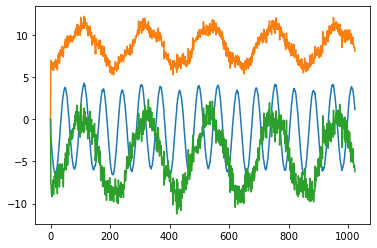

In [41]:
samplePeriod = 1 / 256

i = np.array([1, 0, 0, 0])
gain = 1.0
dt = 0.01
quat = Quaternion(i)

m = Madgwick(acc=acc, gyr=gyr,mag=mag,frequency=100.0)
plt.plot(m.earthAcc)

# Position Integration

## acceleration

## velocity

## position

got position


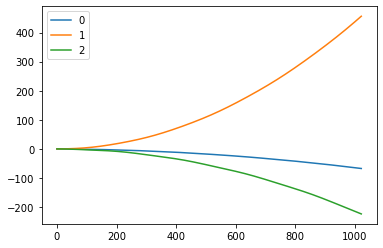

In [42]:
position = get_position(m.earthAcc,m.dt)
position.plot()

In [43]:
position.to_numpy()[:,0]

array([-2.09316686e-04, -6.67440980e-04, -1.42671100e-03, ...,
       -6.70745596e+01, -6.71957866e+01, -6.73168513e+01])

# FFT

## A_xf 

Complex coefficient per frequency 

$A_f = \alpha + i\beta$


A_xf = fftpack.fft(x)


## A_yf


fast fourier transformed
found spread


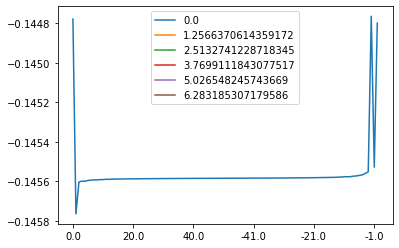

In [44]:
D, A = frequency_analysis(position,dt=m.dt)
D.plot()

C:\Users\starlord\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\starlord\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\starlord\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


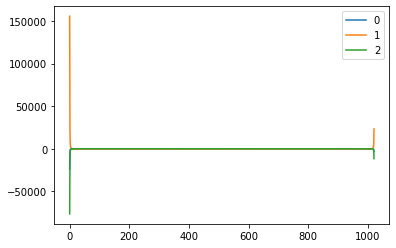

In [45]:
A.plot()

Directional Data

# App

In [46]:
app = dash.Dash(meta_tags=[{
    "name": "viewport",
    "content": "width=device-width, initial-scale=1"
}],
                external_stylesheets=[dbc.themes.LITERA])

In [47]:
navbar = dbc.Navbar([
    dbc.Row(
        [dbc.Col([dbc.NavbarBrand("giglioq", className="navbar-brand")])])
],
                    color='primary',
                    className="navbar navbar-expand-lg navbar-dark bg-primary")

In [48]:
banner = html.Div([
    dbc.Row([
        dbc.Col([
            html.H5("Buoy"),
            html.H3("Welcome to the Buoy Project Dashboard"),
            html.Div(
                id='intro',
                children=
                "Getting things up and running"
            )
        ],
                width={
                    "size": 10,
                    "offset": 1,
                },
                align='center')
    ])
],
                  style={
                      'marginBottom': 20,
                      'marginTop': 20,
                  },
                  id="banner")

In [49]:
plots = html.Div([])

In [50]:
app.layout = html.Div(children=[navbar, banner, plots] )